In [1]:
import sys
sys.path.append("..")
import grading

In [2]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
%matplotlib inline
import matplotlib.pyplot as plt
import download_utils
import keras_utils
import numpy as np
from keras_utils import reset_tf_session

Using TensorFlow backend.


In [3]:
# load images
X, attr = load_lfw_dataset(use_raw = True, dimx = 32, dimy = 32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [4]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


18995

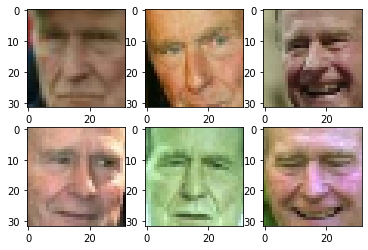

In [5]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2 ,3 , i + 1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

In [6]:
def build_pca_autoencoder(img_shape, code_size):
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  
    encoder.add(L.Dense(code_size))           

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  
    decoder.add(L.Reshape(img_shape))        
    
    return encoder,decoder

In [7]:
#s = reset_tf_session()

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=0)


Epoch 1/15




Epoch 2/15




Epoch 3/15




Epoch 4/15




Epoch 5/15




Epoch 6/15




Epoch 7/15




Epoch 8/15




Epoch 9/15




Epoch 10/15




Epoch 11/15




Epoch 12/15




Epoch 13/15




Epoch 14/15




Epoch 15/15


In [8]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

PCA MSE: 0.007547679269764246


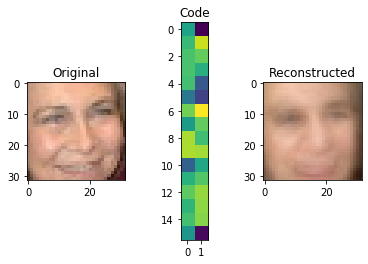

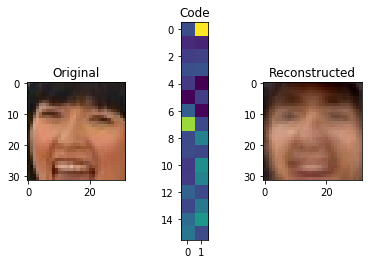

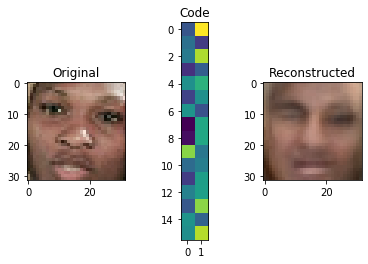

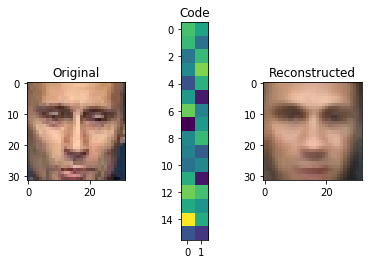

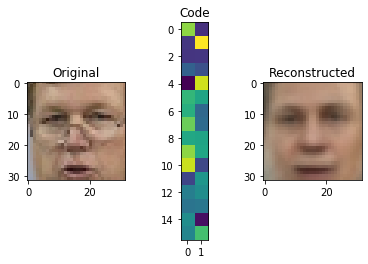

In [9]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

#### Transpose convolution layer

In [10]:
def test_conv2d_transpose(img_size, filter_size):
    
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype = np.float32) + 1).reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype = np.float32)).reshape((filter_size, filter_size, 1, 1))

    #s = reset_tf_session()
    s = tf.compat.v1.Session()
    
    conv = tf.nn.conv2d_transpose(x, f, 
                                  output_shape=(1, img_size * 2, img_size * 2, 1), 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME')

    result = s.run(conv)
    print("input:")
    print(x[0, :, :, 0])
    print("filter:")
    print(f[:, :, 0, 0])
    print("output:")
    print(result[0, :, :, 0])
    s.close()
    
        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

Transpose convolution test for img_size=2, filter_size=2:


RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

In [11]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    ### YOUR CODE HERE: define encoder as per instructions above ###
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    ### YOUR CODE HERE: define decoder as per instructions above ###
    decoder.add(L.Dense(2*2*256))
    decoder.add(L.Reshape((2, 2, 256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [12]:
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    #s = reset_tf_session()
    s = tf.compat.v1.Session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")
#s = reset_tf_session()
s = tf.compat.v1.Session()

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [13]:
s = tf.compat.v1.Session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 4, 4, 256)       

In [14]:
#s = reset_tf_session()
s = tf.compat.v1.Session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [15]:
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

In [ ]:
autoencoder.fit(x=X_train, y=X_train, epochs=12,
                validation_data=[X_test, X_test],
                verbose=0)

In [ ]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [ ]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

### Image Retrieval

In [19]:
s = tf.compat.v1.Session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
#encoder.load_weights("encoder.h5")

In [20]:
images = X_train
codes = encoder.predict(images) ### YOUR CODE HERE: encode all images ###
assert len(codes) == len(images)

In [22]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [23]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [24]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

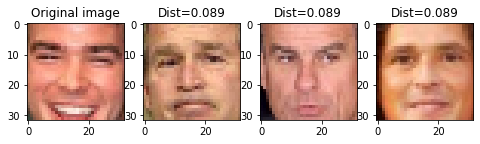

In [25]:
show_similar(X_test[247])

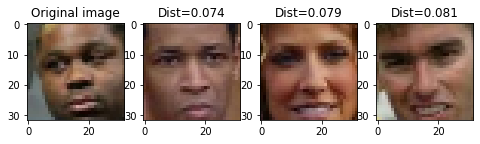

In [26]:
# ethnicity
show_similar(X_test[56])

### Image Morphing

In [28]:
s = tf.compat.v1.Session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

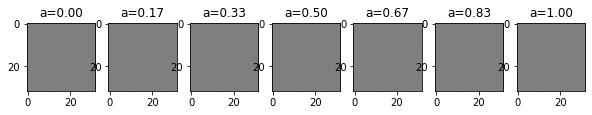

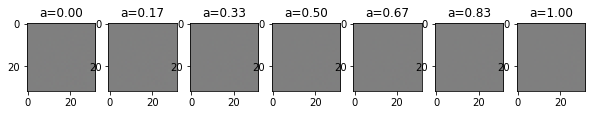

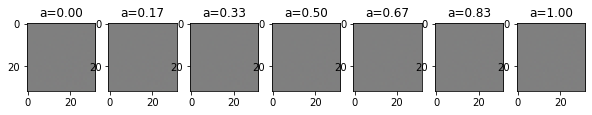

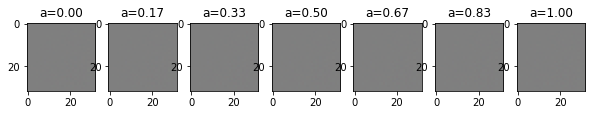

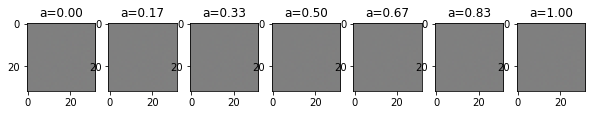

In [30]:
for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1, image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        show_image(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()